# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.800663,False,-0.146266
1,-1.232943,False,-0.770699
2,0.803699,True,5.967341
3,-0.269387,True,4.085870
4,-1.146332,True,4.347502
...,...,...,...
995,0.434108,False,0.569943
996,-1.157220,False,-2.058845
997,2.486762,True,8.578428
998,-2.413422,False,-6.190951


<Axes: xlabel='v0'>

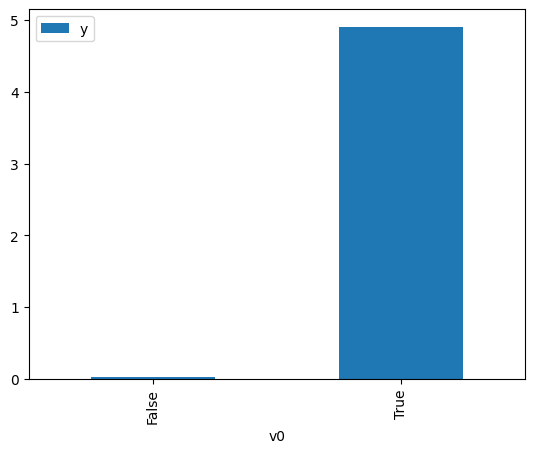

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

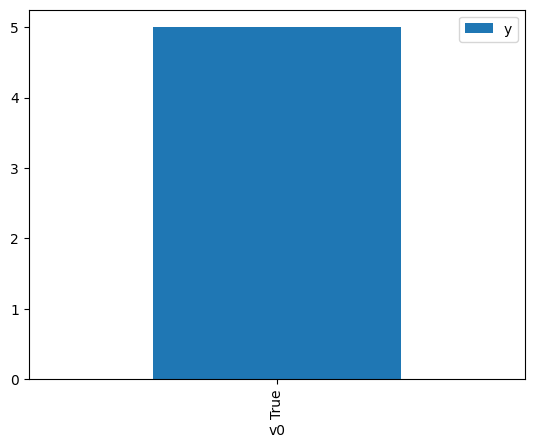

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.479597,False,-2.763572,0.655638,1.525231
1,0.508643,False,2.022683,0.361489,2.766339
2,-2.070150,False,-3.850474,0.930600,1.074576
3,2.111224,False,4.877410,0.073394,13.625134
4,-1.300236,False,-2.150423,0.839033,1.191848
...,...,...,...,...,...
995,0.657899,False,0.072443,0.320367,3.121417
996,1.113710,False,1.543322,0.212239,4.711671
997,-1.153829,False,-2.395445,0.813266,1.229610
998,-1.413041,False,-2.113652,0.856865,1.167045


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.895064,True,3.590504,0.239795,4.170224
1,0.385253,True,5.587635,0.602880,1.658706
2,0.875230,True,5.580090,0.734740,1.361026
3,0.230453,True,5.283834,0.556630,1.796524
4,-1.592298,True,0.360369,0.118210,8.459501
...,...,...,...,...,...
995,0.393378,True,5.416889,0.605264,1.652171
996,0.760959,True,5.846128,0.706525,1.415378
997,-0.492237,True,3.198383,0.340868,2.933689
998,0.572175,True,4.363068,0.656307,1.523677


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              9806.
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        16:49:06   Log-Likelihood:                         -1430.2
No. Observations:                1000   AIC:                                      2864.
Df Residuals:                     998   BIC:                                      2874.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9282      0.035     54.487      0.000       1.859       1.998
x2             4.9429      0.048    102.092      0.000       4.848       5.038
==============================================================================
Omnibus:                        3.613   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.509
Skew:                           0.143   Prob(JB):                        0.173
Kurtosis:                       3.054   Cond. No.                         1.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""